<a href="https://colab.research.google.com/github/santausd/USD-AAI-530-A1-Assignment3.1/blob/main/LSTM_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions
from google.colab import drive
from sklearn.model_selection import train_test_split

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [3]:
#Load your data into a pandas dataframe here
drive.mount('/content/drive')
file_path = f'/content/drive/My Drive/AAI-530-A1/clean_data.csv'  # Assuming 'clean_data.csv' is directly in 'My Drive'

fullset_df = pd.read_csv(file_path)
fullset_df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Time                   object 
 3   Global_active_power    float64
 4   Global_reactive_power  float64
 5   Voltage                float64
 6   Global_intensity       float64
 7   Sub_metering_1         float64
 8   Sub_metering_2         float64
 9   Sub_metering_3         float64
 10  Datetime               object 
 11  Month                  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 190.0+ MB


In [4]:
fullset_df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,Month
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,2006-12
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,2006-12
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,2006-12
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,2006-12
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,2006-12


In [5]:
#create your training and validation sets here
#assign size for data subset
#take random data subset
random_state = 1123456
df = fullset_df.sample(frac=0.01,  random_state=random_state)

#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)


In [6]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [7]:
seq_arrays = []
seq_labs = []

In [8]:
#Format dataset as per requirement.
def restructure_data(data, seq_length, ph, feat_cols, seq_arrays, seq_labs):
    temp_seq_arrays = []
    temp_seq_labs = []

    #create list of sequence length GAP readings
    for i in range(len(data) - seq_length - ph):
        temp_seq_arrays.append(data[feat_cols][i : i + seq_length].values.reshape(-1, len(feat_cols)))
        temp_seq_labs.append(data['Global_active_power'][i + seq_length + ph -1])


    #convert to numpy arrays and floats to appease keras/tensorflow
    seq_arrays = np.array(temp_seq_arrays, dtype = object).astype(np.float32)
    seq_labs = np.array(temp_seq_labs, dtype = object).astype(np.float32)

    return seq_arrays, seq_labs


In [9]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']
seq_arrays, seq_labs = restructure_data(train_df, seq_length, ph, feat_cols, seq_arrays, seq_labs)


In [10]:
def check_dimensions(seq_arrays, seq_labs, data, feat_cols, seq_length, ph):
    print('Shape of arrays: ', seq_arrays.shape)
    print('Shape of labbel', seq_labs.shape)
    assert(seq_arrays.shape == (len(data)-seq_length-ph,seq_length, len(feat_cols)))
    assert(seq_labs.shape == (len(data)-seq_length-ph,))


In [11]:
seq_arrays, seq_labs = restructure_data(train_df, seq_length, ph, feat_cols, seq_arrays, seq_labs)
check_dimensions(seq_arrays, seq_labs,train_df, feat_cols, seq_length, ph)

Shape of arrays:  (16567, 30, 1)
Shape of labbel (16567,)


**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:
The assert statements is used to validate whether any prerequisite/condition is successfully met. This is used for fail early strategy as a part of debugging.

In this case, the assert statement is used to ensure that dimensions of seq_arrays and seq_labs are met early.


## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [12]:
def train_model(file_count, seq_arrays, seq_labs, seq_length, model_parameter):
  # define path to save model
  model_path = 'LSTM_model%d.keras'%(file_count)
  print(model_path)

  # build the network
  nb_features = seq_arrays.shape[2]
  nb_out = 1

  model = Sequential()

  #add first LSTM layer
  model.add(LSTM(
          input_shape=(seq_length, nb_features),
          #units=5,
          units=model_parameter['hidden_layer_1_neuron_count'] ,
          return_sequences=True)),
  #model.add(Dropout(0.4))
  model.add(Dropout(model_parameter['hidden_layer_1_dropout_rate']))


  # add second LSTM layer
  model.add(LSTM(
            units=model_parameter['hidden_layer_2_neuron_count'] ,
            return_sequences=False))
  model.add(Dropout(0.4))


  #model.add(Dense(units=nb_out, activation='linear'))
  model.add(Dense(units=nb_out))
  #model.add(Activation('linear'))
  model.add(Activation(model_parameter['activation_funcation']))

  #optimizer = keras.optimizers.Adam(learning_rate = 0.01))
  optimizer = keras.optimizers.Adam(learning_rate = model_parameter['learning_rate'])
  model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

  print(model.summary())

  # fit the network
  history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
            )

  # list all data in history
  print(history.history.keys())
  return model, history


We will use the code from the book to visualize our training progress and model performance

In [13]:
def visualize_loss(file_count, history):
  # summarize history for Loss/MSE
  fig_acc = plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss/MSE')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  fig_acc.savefig("LSTM_loss1.png")



In [14]:
def model_evaluate_pred(file_count, model, val_arrays, val_labs):
  scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
  print('\nMSE: {}'.format(scores_test[1]))

  y_pred_test = model.predict(val_arrays)
  y_true_test = val_labs

  test_set = pd.DataFrame(y_pred_test)
  test_set.to_csv('submit_test{}.csv'.format(file_count), index = None)

  # Plot the predicted data vs. the actual data
  # we will limit our plot to the first 500 predictions for better visualization
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_pred_test[-500:], label = 'Predicted Value')
  plt.plot(y_true_test[-500:], label = 'Actual Value')
  plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend()
  plt.show()
  fig_verify.savefig("model_regression_verify{}.png".format(file_count))



LSTM_model1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 5)               │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 6s - 175ms/step - loss: 1.4686 - mse: 1.4686 - val_loss: 1.1972 - val_mse: 1.1972
Epoch 2/100
32/32 - 2s - 63ms/step - loss: 1.2498 - mse: 1.2498 - val_loss: 1.1623 - val_mse: 1.1623
Epoch 3/100
32/32 - 1s - 40ms/step - loss: 1.1989 - mse: 1.1989 - val_loss: 1.1547 - val_mse: 1.1547
Epoch 4/100
32/32 - 3s - 93ms/step - loss: 1.1726 - mse: 1.1726 - val_loss: 1.1515 - val_mse: 1.1515
Epoch 5/100
32/32 - 2s - 58ms/step - loss: 1.1461 - mse: 1.1461 - val_loss: 1.1522 - val_mse: 1.1522
Epoch 6/100
32/32 - 1s - 35ms/step - loss: 1.1348 - mse: 1.1348 - val_loss: 1.1509 - val_mse: 1.1509
Epoch 7/100
32/32 - 1s - 37ms/step - loss: 1.1287 - mse: 1.1287 - val_loss: 1.1515 - val_mse: 1.1515
Epoch 8/100
32/32 - 1s - 34ms/step - loss: 1.1227 - mse: 1.1227 - val_loss: 1.1508 - val_mse: 1.1508
Epoch 9/100
32/32 - 1s - 39ms/step - loss: 1.1212 - mse: 1.1212 - val_loss: 1.1507 - val_mse: 1.1507
Epoch 10/100
32/32 - 1s - 39ms/step - loss: 1.1180 - mse: 1.1180 - val_loss: 1.1507 -

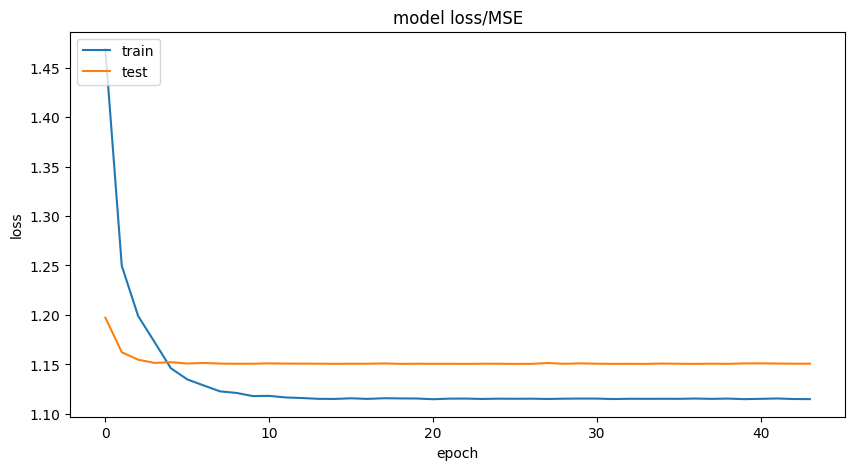

In [15]:
model_parameter = {}
model_parameter['hidden_layer_1_neuron_count'] = 5
model_parameter['hidden_layer_1_dropout_rate'] = 0.4
model_parameter['hidden_layer_2_neuron_count'] = 3
model_parameter['learning_rate'] = 0.01
model_parameter['activation_funcation'] = 'linear'
file_count = 1

model, history = train_model(file_count=file_count, seq_arrays=seq_arrays, seq_labs=seq_labs, seq_length=seq_length, model_parameter=model_parameter)
visualize_loss(file_count,history )



## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A:

In [16]:
val_arrays = []
val_labs = []

In [17]:
val_arrays, val_labs = restructure_data(val_df, seq_length, ph, feat_cols, seq_arrays, seq_labs)
check_dimensions(val_arrays, val_labs, val_df, feat_cols, seq_length, ph)

Shape of arrays:  (4116, 30, 1)
Shape of labbel (4116,)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

129/129 - 1s - 6ms/step - loss: 1.0044 - mse: 1.0044

MSE: 1.0043907165527344
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


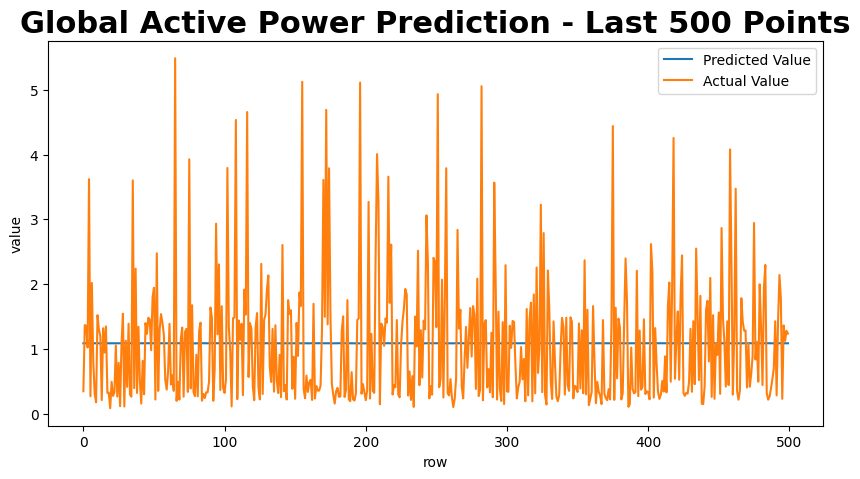

In [18]:
model_evaluate_pred(file_count, model, val_arrays, val_labs)

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model has performed pretty well against the training dataset. The training loss is reduced to 1.1154. However, the model did not perform well against the validation dataset as the validation loss continues to remain around val_loss: 1.1504 and val_mse: 1.1504 throught the entire phase.

It appears that the model has overfitting issues since it is doing pretty well against training dataset but not against validation dataset.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: I would like to try with first three approaches to opmitise the model.
1. - Add more variables to the input sequences
2. - Change the optimizer and/or adjust the learning rate
3. - Change the sequence length and/or the predictive horizon

All these changes should reduce the overall errort (mse) and improve the accuracy of the model.

Shape of arrays:  (16567, 30, 3)
Shape of labbel (16567,)
Shape of arrays:  (4116, 30, 3)
Shape of labbel (4116,)
LSTM_model1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 5)               │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292 (1.14 KB)

 Trainable params: 292 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 7s - 205ms/step - loss: 1.4282 - mse: 1.4282 - val_loss: 1.1616 - val_mse: 1.1616
Epoch 2/100
32/32 - 2s - 48ms/step - loss: 1.2453 - mse: 1.2453 - val_loss: 1.1595 - val_mse: 1.1595
Epoch 3/100
32/32 - 2s - 74ms/step - loss: 1.2028 - mse: 1.2028 - val_loss: 1.1558 - val_mse: 1.1558
Epoch 4/100
32/32 - 2s - 70ms/step - loss: 1.1764 - mse: 1.1764 - val_loss: 1.1515 - val_mse: 1.1515
Epoch 5/100
32/32 - 3s - 79ms/step - loss: 1.1535 - mse: 1.1535 - val_loss: 1.1510 - val_mse: 1.1510
Epoch 6/100
32/32 - 2s - 50ms/step - loss: 1.1400 - mse: 1.1400 - val_loss: 1.1509 - val_mse: 1.1509
Epoch 7/100
32/32 - 2s - 48ms/step - loss: 1.1272 - mse: 1.1272 - val_loss: 1.1508 - val_mse: 1.1508
Epoch 8/100
32/32 - 1s - 42ms/step - loss: 1.1240 - mse: 1.1240 - val_loss: 1.1506 - val_mse: 1.1506
Epoch 9/100
32/32 - 1s - 41ms/step - loss: 1.1226 - mse: 1.1226 - val_loss: 1.1505 - val_mse: 1.1505
Epoch 10/100
32/32 - 2s - 74ms/step - loss: 1.1188 - mse: 1.1188 - val_loss: 1.1505 -

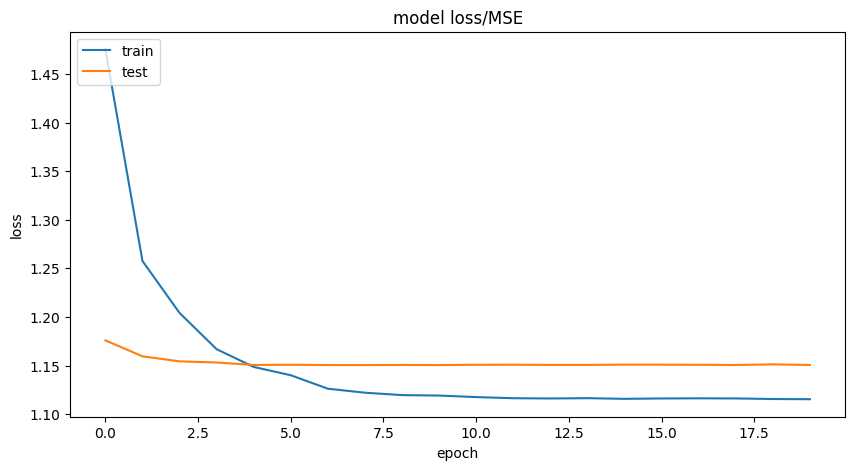

129/129 - 1s - 9ms/step - loss: 1.0034 - mse: 1.0034

MSE: 1.0034146308898926
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


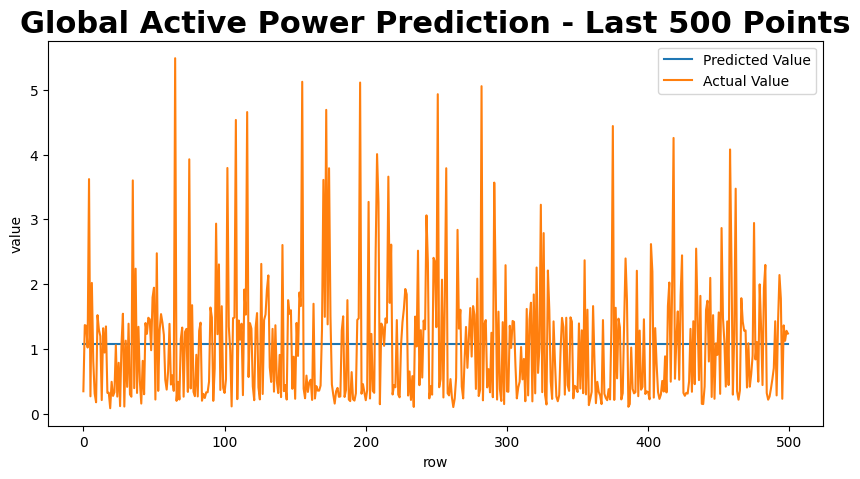

In [25]:
#1. Optimisation idea : introduce more feature variables.
seq_length = 30
ph = 5
feat_cols = ['Global_active_power', 'Voltage',  'Sub_metering_1']
seq_arrays = []
seq_labs = []
val_arrays = []
val_labs = []


seq_arrays, seq_labs = restructure_data(train_df, seq_length, ph, feat_cols, seq_arrays, seq_labs)
val_arrays, val_labs = restructure_data(val_df, seq_length, ph, feat_cols, val_arrays, val_labs)

check_dimensions(seq_arrays, seq_labs, train_df, feat_cols, seq_length, ph)
check_dimensions(val_arrays, val_labs, val_df, feat_cols, seq_length, ph)

train_model(file_count, seq_arrays, seq_labs, seq_length, model_parameter)
visualize_loss(file_count,history )
model_evaluate_pred(file_count, model, val_arrays, val_labs)

Shape of arrays:  (16567, 30, 3)
Shape of labbel (16567,)
Shape of arrays:  (4116, 30, 3)
Shape of labbel (4116,)
LSTM_model1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 5)               │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292 (1.14 KB)

 Trainable params: 292 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 6s - 193ms/step - loss: 1.2598 - mse: 1.2598 - val_loss: 1.1611 - val_mse: 1.1611
Epoch 2/100
32/32 - 1s - 36ms/step - loss: 1.1236 - mse: 1.1236 - val_loss: 1.1505 - val_mse: 1.1505
Epoch 3/100
32/32 - 4s - 127ms/step - loss: 1.1157 - mse: 1.1157 - val_loss: 1.1505 - val_mse: 1.1505
Epoch 4/100
32/32 - 7s - 204ms/step - loss: 1.1161 - mse: 1.1161 - val_loss: 1.1536 - val_mse: 1.1536
Epoch 5/100
32/32 - 6s - 181ms/step - loss: 1.1172 - mse: 1.1172 - val_loss: 1.1505 - val_mse: 1.1505
Epoch 6/100
32/32 - 1s - 39ms/step - loss: 1.1154 - mse: 1.1154 - val_loss: 1.1508 - val_mse: 1.1508
Epoch 7/100
32/32 - 1s - 39ms/step - loss: 1.1159 - mse: 1.1159 - val_loss: 1.1505 - val_mse: 1.1505
Epoch 8/100
32/32 - 1s - 33ms/step - loss: 1.1157 - mse: 1.1157 - val_loss: 1.1517 - val_mse: 1.1517
Epoch 9/100
32/32 - 1s - 35ms/step - loss: 1.1162 - mse: 1.1162 - val_loss: 1.1520 - val_mse: 1.1520
Epoch 10/100
32/32 - 2s - 57ms/step - loss: 1.1151 - mse: 1.1151 - val_loss: 1.150

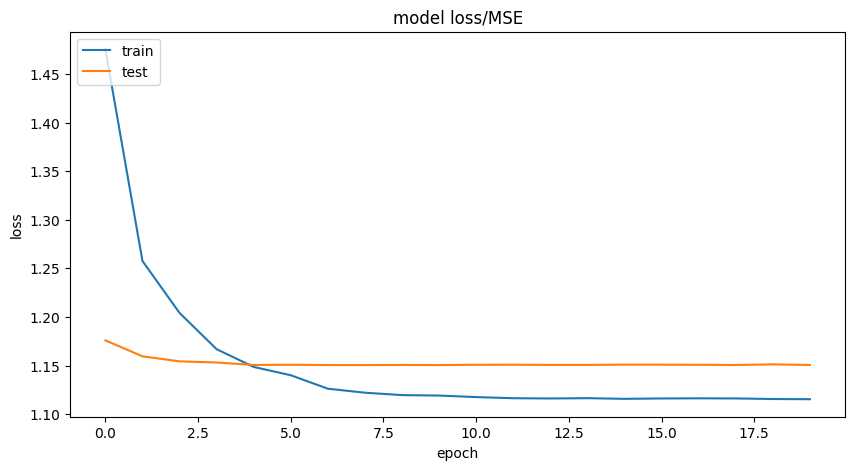

129/129 - 1s - 6ms/step - loss: 1.0034 - mse: 1.0034

MSE: 1.0034146308898926
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


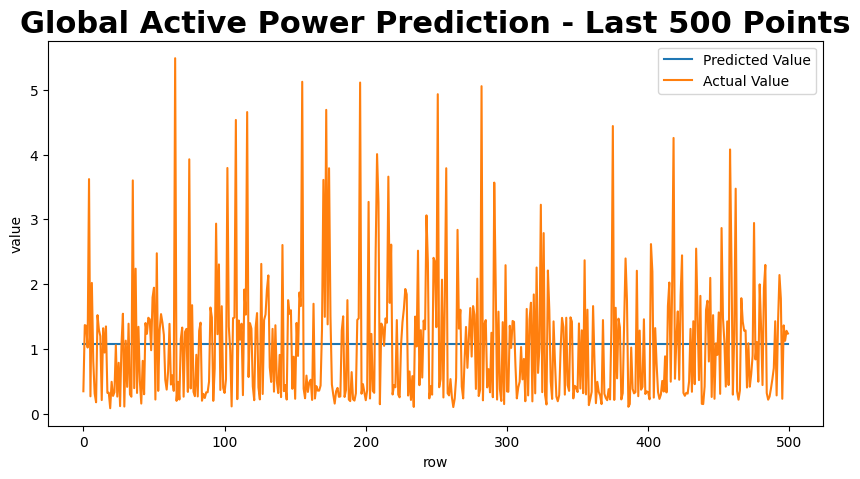

In [26]:
#Optimisation Idea 2:  adjust the learning rate
model_parameter = {}
model_parameter['hidden_layer_1_neuron_count'] = 5
model_parameter['hidden_layer_1_dropout_rate'] = 0.4
model_parameter['hidden_layer_2_neuron_count'] = 3
model_parameter['learning_rate'] = 0.05
model_parameter['activation_funcation'] = 'linear'
file_count = 1
seq_length = 30
ph = 5
feat_cols = ['Global_active_power', 'Voltage',  'Sub_metering_1']
seq_arrays = []
seq_labs = []
val_arrays = []
val_labs = []


seq_arrays, seq_labs = restructure_data(train_df, seq_length, ph, feat_cols, seq_arrays, seq_labs)
val_arrays, val_labs = restructure_data(val_df, seq_length, ph, feat_cols, val_arrays, val_labs)

check_dimensions(seq_arrays, seq_labs, train_df, feat_cols, seq_length, ph)
check_dimensions(val_arrays, val_labs, val_df, feat_cols, seq_length, ph)

train_model(file_count, seq_arrays, seq_labs, seq_length, model_parameter)
visualize_loss(file_count,history )
model_evaluate_pred(file_count, model, val_arrays, val_labs)


Shape of arrays:  (16545, 50, 3)
Shape of labbel (16545,)
Shape of arrays:  (4094, 50, 3)
Shape of labbel (4094,)
LSTM_model1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 50, 5)               │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292 (1.14 KB)

 Trainable params: 292 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 8s - 250ms/step - loss: 1.2313 - mse: 1.2313 - val_loss: 1.1511 - val_mse: 1.1511
Epoch 2/100
32/32 - 2s - 63ms/step - loss: 1.1186 - mse: 1.1186 - val_loss: 1.1523 - val_mse: 1.1523
Epoch 3/100
32/32 - 2s - 50ms/step - loss: 1.1154 - mse: 1.1154 - val_loss: 1.1521 - val_mse: 1.1521
Epoch 4/100
32/32 - 2s - 50ms/step - loss: 1.1143 - mse: 1.1143 - val_loss: 1.1533 - val_mse: 1.1533
Epoch 5/100
32/32 - 3s - 78ms/step - loss: 1.1155 - mse: 1.1155 - val_loss: 1.1514 - val_mse: 1.1514
Epoch 6/100
32/32 - 2s - 75ms/step - loss: 1.1145 - mse: 1.1145 - val_loss: 1.1511 - val_mse: 1.1511
Epoch 7/100
32/32 - 3s - 84ms/step - loss: 1.1153 - mse: 1.1153 - val_loss: 1.1514 - val_mse: 1.1514
Epoch 8/100
32/32 - 4s - 129ms/step - loss: 1.1153 - mse: 1.1153 - val_loss: 1.1511 - val_mse: 1.1511
Epoch 9/100
32/32 - 2s - 76ms/step - loss: 1.1148 - mse: 1.1148 - val_loss: 1.1524 - val_mse: 1.1524
Epoch 10/100
32/32 - 2s - 51ms/step - loss: 1.1153 - mse: 1.1153 - val_loss: 1.1512 

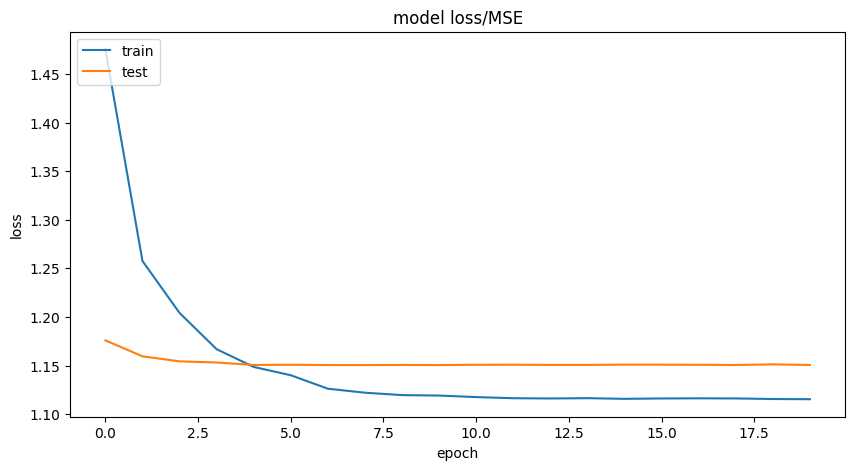

128/128 - 2s - 14ms/step - loss: 1.0046 - mse: 1.0046

MSE: 1.0046223402023315
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


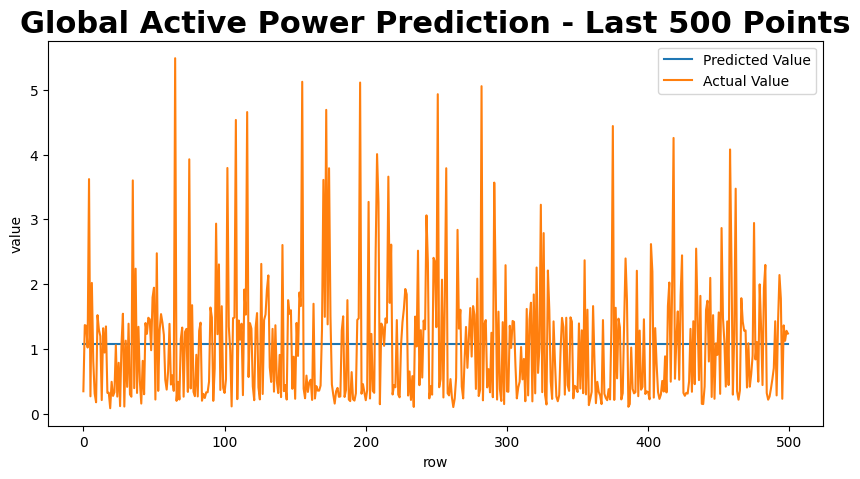

In [27]:
#3. Optimisation idea: Change the sequence length and prediction horizon
seq_length = 50
ph = 7
feat_cols = ['Global_active_power', 'Voltage',  'Sub_metering_1']
seq_arrays = []
seq_labs = []
val_arrays = []
val_labs = []


seq_arrays, seq_labs = restructure_data(train_df, seq_length, ph, feat_cols, seq_arrays, seq_labs)
val_arrays, val_labs = restructure_data(val_df, seq_length, ph, feat_cols, val_arrays, val_labs)

check_dimensions(seq_arrays, seq_labs, train_df, feat_cols, seq_length, ph)
check_dimensions(val_arrays, val_labs, val_df, feat_cols, seq_length, ph)

train_model(file_count, seq_arrays, seq_labs, seq_length, model_parameter)
visualize_loss(file_count,history )
model_evaluate_pred(file_count, model, val_arrays, val_labs)

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The overall performance using these methods are negligible. The error rate for training dataset and validation dataset are in the similar range but does not offer any noticeable improvement.

The model suffers from overfiting of training dataset.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Model development using LSTM is little complex compared to linear regression. The main difference between this two models is LSTM is based on unsupervised so it does not required labelled dataset wheras linear regression requires labelled dataset for training.

I would prefer LSTM for predicting GAP.